# Convolving ECCO adjoint sensitivities with other fields
E Boland 2021 - contact emmomp@bas.ac.uk for any issues

Examples loading CMIP inter-model spreads and ECCO external forcing data and convolving with ECCO sensitivities.

Requires the ecco_v4_py library to read/plot ECCO data on the LLC grid, available here: https://github.com/ECCO-GROUP/ECCOv4-py/

In [1]:
import xarray as xr
import ecco_v4_py as ecco
import numpy as np
import pyresample
import matplotlib.pyplot as plt
import dask

## 1. Load ECCO sensitivities

First define year(s), basin(s), variable(s) required

In [2]:
ecco_dir = '/gws/nopw/j04/orchestra_vol2/ADJOINT_RESULTS/SO_modewater_8yr_nctiles/' #JASMIN holding location, membership of ORCHESTRA group required for access
years = ['1999'] # 1999-2011 available
#years=[str(x) for x in range(1999,2012)]
basins = ['atl','pac','ind'] # List from ['atl','pac','ind']
ecco_vars=['ADJsaltsurf', 'ADJthetasurf', 'adxx_qnet', 'adxx_tauu', 'adxx_tauv'] # List from ['ADJsaltsurf', 'ADJthetasurf', 'adxx_qnet', 'adxx_tauu', 'adxx_tauv']

In [3]:
ecco_grid=xr.open_dataset('~/encore/convolve/data_in/ECCOv4r3_grid.nc') 

ecco_data=[]
for basin in basins:
    ecco_data_basin=[]
    for year in years:
        adj_sens = xr.open_mfdataset(ecco_dir+year+'/'+basin+'/*[a-zA-Z].nc')
        adj_sens=adj_sens.swap_dims({'time':'lag_years'})
        adj_sens['basin']=(('basin',[basin,]))
        adj_sens['year']=(('year',[year,]))
        ecco_data_basin.append(adj_sens)
    ecco_data.append(xr.concat(ecco_data_basin,'year'))
    
ecco_data=xr.concat(ecco_data,'basin')
if 'adxx_tauu' in ecco_vars:
    ecco_data['adxx_tauu']=-ecco_data['adxx_tauu']
if 'adxx_tauv' in ecco_vars:
    ecco_data['adxx_tauv']=-ecco_data['adxx_tauv']

## 2. Define convolving function and regridding functions

In [4]:
def convolve_ecco(ecco_data,convolve_data,ecco_convolve_map,regrid=True,dir_out=None):
    
    # Function to convolve ECCO adjoint sensitivities with given fields to produce convolutions
    # ECCO data regridded to 1deg grid automatically, and, if convolve data is time-dependent, the sensetivities are resampled in time to match
    # 
    # Parameters
    # ----------
    # ecco_data : xarray dataset 
    #      ECCO sensitivities to convolve
    # convolve_data : xarray dataset
    #      Fields to convolve with ECCO data
    # ecco_convolve_map : dict
    #      Mapping from each ecco_data variable to convolve_data variable or list of variables. Used to match variables to convolve together
    # regrid : logical
    #      If True (default), regrid ecco_data to convolve_data grid, must have variables 'lon' and 'lat' 
    # dir_out : str
    #      Directory to write data_out to. If None (default), no data written
    #
    # Returns
    # -------
    # data_all : xarray dataset
    #      Convolved data, returned as variables with names '[ecco_var]X[convolve_var]', 
    #      where 'ecco_var' and 'convolve_var' are variables from ecco_data and convolve_data respectively
    
    if regrid:   
        regridder=setup_regrid(ecco_grid.XC,ecco_grid.YC,convolve_data.lon,convolve_data.lat) 
     
    data_all = []
    
    for var in list(ecco_data.data_vars):
        data_all_var=[]
        for basin in list(ecco_data.basin.values):
            data_all_basin=[]
            for year in list(ecco_data.year.values):
                print(var,basin,year)
                din = ecco_data[var].sel(basin=basin,year=year)
                # Regrid in space if necessary
                if regrid: 
                    din=repeat_regrid(din,regridder,convolve_data.lon,convolve_data.lat)
                    if 'year' in ecco_data['time'].dims:
                        din['time']=ecco_data['time'].sel(year=year)
                    else:
                        din['time']=ecco_data['time']
                    
                data_out=None
                for cvar in ecco_convolve_map[var]: 
                    # Resample in time if necessary
                    if ('time' in convolve_data) :
                        if convolve_data[cvar]['time'].size>1:
                            if 'time' not in din.dims:
                                din=din.swap_dims({'lag_years':'time'})
                            din = din.interp(time=convolve_data[cvar]['time'])
                            data_convolve = din*convolve_data[cvar] 
                            data_convolve=data_convolve.swap_dims({'time':'lag_years'})
                        else:
                            data_convolve = din*convolve_data[cvar] 
                    else:
                    # Perform convolution 
                        data_convolve = din*convolve_data[cvar] 
                                                
                    # Take means (sensitivities already area weighted)
                    dims = list(data_convolve.dims)
                    dims.remove('lag_years')
                    data_convolve_mean=data_convolve.mean(dim=dims)
                    data_convolve_absmean=np.abs(data_convolve).mean(dim=dims)
                    
                    # Put in a dataset
                    out_dict={'{}X{}'.format(var,cvar):data_convolve,
                            '{}X{}_mean'.format(var,cvar):data_convolve_mean,
                            '{}X{}_absmean'.format(var,cvar):data_convolve_absmean}
                    if data_out is None:
                        data_out=xr.Dataset(data_vars=out_dict)
                    else:
                        data_out=data_out.assign(out_dict)
                        
                data_out['basin']=(('basin',[basin,]))
                data_out['year']=(('year',[year,]))   
                    
                data_all_basin.append(data_out)
            data_all_var.append(xr.concat(data_all_basin,'year'))
         
        data_all_var=xr.combine_nested(data_all_var,['basin'])
        data_all.append(data_all_var)
        # Write to file if required
        if dir_out is not None:
            data_all_var.to_netcdf(dir_out+'/ECCOconv_{}.nc'.format(var))  
            print('Written to',dir_out+'/ECCOconv_{}.nc'.format(var))
                
    data_all = xr.merge(data_all)
    return data_all
                

In [5]:
def setup_regrid(xc,yc,new_lon=np.linspace(-179,180,360),new_lat=np.linspace(-89.5,89.5,180)):
    orig_grid = pyresample.geometry.SwathDefinition(lons=xc.values.ravel(), lats=yc.values.ravel())
    yi,xi=np.meshgrid(new_lat,new_lon)
    new_grid  = pyresample.geometry.GridDefinition(lons=xi,lats=yi)
    resample_data = pyresample.kd_tree.get_neighbour_info(orig_grid, new_grid, 100000, neighbours=1)
    return resample_data   

def repeat_regrid(ds,resample_data,new_lon=np.linspace(-179,180,360), new_lat=np.linspace(-89.5,89.5,180),loop_dim='lag_years'):    
    grid_shape=[new_lon.size,new_lat.size]
    stack_dims=ds.dims[1:]
    foo = pyresample.kd_tree.get_sample_from_neighbour_info('nn', grid_shape, ds.stack(z=stack_dims).transpose(...,loop_dim).values,
                                              resample_data[0], resample_data[1],resample_data[2])    
    ds2=xr.DataArray(foo,dims=['lon','lat',loop_dim],coords={'lon':(('lon'),new_lon),'lat':(('lat'),new_lat),loop_dim:(loop_dim,ds[loop_dim])})
    return ds2

## Example 1: CMIP5 spread data

Created using CMIP5_ranges notebook, available from https://github.com/emmomp/CMIP_spreads

### 1.1. Define map between CMIP and ECCO variables and load the data

In [6]:
cmip_ecco_map={'ADJthetasurf':['tos_std','tos_spread'],'ADJsaltsurf':['sos_std',],'adxx_qnet':['hfds_std',],'adxx_tauu':['tauuo_std',],'adxx_tauv':['tauvo_std',]}
cmip_dir='~/encore/cmip/data_out'
cmip_vars=['tos','sos','hfds','tauuo','tauvo']

def pre_proc(ds):
    fname=ds.encoding["source"]
    var=fname.split('_')[-2]
    ds=ds.rename_vars({'model_std':'{}_std'.format(var),'model_spread':'{}_spread'.format(var)})
    return ds

cmip_spreads=xr.open_mfdataset(cmip_dir+'/cmip5_stdspread_*_model.nc',preprocess=pre_proc)

### 1.2. Perform the convolution

Provide optional input 'dir_out' to have convolutions written to file

In [7]:
cmip5_out=convolve_ecco(ecco_data,cmip_spreads.mean(dim='time'),cmip_ecco_map)

ADJsaltsurf atl 1999
ADJsaltsurf pac 1999
ADJsaltsurf ind 1999
ADJthetasurf atl 1999
ADJthetasurf pac 1999
ADJthetasurf ind 1999
adxx_qnet atl 1999
adxx_qnet pac 1999
adxx_qnet ind 1999
adxx_tauu atl 1999
adxx_tauu pac 1999
adxx_tauu ind 1999
adxx_tauv atl 1999
adxx_tauv pac 1999
adxx_tauv ind 1999


## Example 2: CMIP6 spread data

Created using CMIP6_ranges notebook, available from https://github.com/emmomp/CMIP_spreads

### 2.1. Define map between CMIP and ECCO variables and load the data

In [8]:
cmip_ecco_map={'ADJthetasurf':['tos_std','tos_spread'],'ADJsaltsurf':['sos_std',],'adxx_qnet':['hfds_std',],'adxx_tauu':['tauuo_std',],'adxx_tauv':['tauvo_std',]}
cmip_dir='/home/users/eboland/encore/cmip/data_out'
cmip_vars=['tos','sos','hfds','tauuo','tauvo']

def pre_proc(ds):
    fname=ds.encoding["source"]
    var=fname.split('_')[-2]
    ds=ds.rename_vars({'model_std':'{}_std'.format(var),'model_spread':'{}_spread'.format(var)})
    return ds

cmip6_spreads=xr.open_mfdataset(cmip_dir+'/cmip6_stdspread_*_model.nc',preprocess=pre_proc)

In [9]:
cmip6_out=convolve_ecco(ecco_data,cmip6_spreads,cmip_ecco_map)

ADJsaltsurf atl 1999
ADJsaltsurf pac 1999
ADJsaltsurf ind 1999
ADJthetasurf atl 1999
ADJthetasurf pac 1999
ADJthetasurf ind 1999
adxx_qnet atl 1999
adxx_qnet pac 1999
adxx_qnet ind 1999
adxx_tauu atl 1999
adxx_tauu pac 1999
adxx_tauu ind 1999
adxx_tauv atl 1999
adxx_tauv pac 1999
adxx_tauv ind 1999


## Example 3: ECCO forcing data

### 3.1. Define map between adjoint and forcing variables, and load the data

In [10]:
exf_vars=['THETA','SALT','EXFqnet','EXFtaue','EXFtaun']
# Create weights for Southern Ocean mean
somask=(ecco_grid.YC<-25) & (ecco_grid.YC>=-65)
weight=somask*ecco_grid.rA*ecco_grid.hFacC.isel(k=0)

# Load data for 3D standard deviations, calculating domain mean too
ecco_exf_data=[]
for var in exf_vars:    
    if var in ['THETA','SALT']: #3D variables
        sig3d=ecco.read_llc_to_tiles('/home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms',var+'.bin',use_xmitgcm=True,nk=50)
        sig3dsurf=sig3d[0,0,:,:,:] 
        sig3d_ds=xr.DataArray(data=sig3dsurf,dims=['tile','j','i'],name=var+'surf')        
    else:
        sig3d=ecco.read_llc_to_tiles('/home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms',var+'.bin',use_xmitgcm=True)
        sig3d_ds=xr.DataArray(data=sig3d.squeeze(),dims=['tile','j','i'],name=var)
    sig0_ds=sig3d_ds.weighted(weight).mean()
    sig0_ds=sig0_ds.rename(sig3d_ds.name+'0')
    # Rename to align with ECCO adjoint grid output
    if var=='EXFtaue':
        sig3d_ds=sig3d_ds.rename({'i':'i_g'})
    elif var=='EXFtaun':
        sig3d_ds=sig3d_ds.rename({'j':'j_g'})
    ecco_exf_data.append(sig3d_ds)
    ecco_exf_data.append(sig0_ds)
ecco_exf_data=xr.merge(ecco_exf_data)

ecco3d_ecco_map={'ADJthetasurf':['THETAsurf','THETAsurf0'],'ADJsaltsurf':['SALTsurf','SALTsurf0'],'adxx_qnet':['EXFqnet','EXFqnet0'],
                 'adxx_tauu':['EXFtaue','EXFtaue0'],'adxx_tauv':['EXFtaun','EXFtaun0']}

read_llc_to_tiles: full_filename:  /home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms/THETA.bin
read_llc_to_tiles: full_filename:  /home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms/SALT.bin
read_llc_to_tiles: full_filename:  /home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms/EXFqnet.bin
read_llc_to_tiles: full_filename:  /home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms/EXFtaue.bin
read_llc_to_tiles: full_filename:  /home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms/EXFtaun.bin


### 3.2. Perform the convolution

In [11]:
eccoexf_out=convolve_ecco(ecco_data,ecco_exf_data,ecco3d_ecco_map,regrid=False)

ADJsaltsurf atl 1999
ADJsaltsurf pac 1999
ADJsaltsurf ind 1999
ADJthetasurf atl 1999
ADJthetasurf pac 1999
ADJthetasurf ind 1999
adxx_qnet atl 1999
adxx_qnet pac 1999
adxx_qnet ind 1999
adxx_tauu atl 1999
adxx_tauu pac 1999
adxx_tauu ind 1999
adxx_tauv atl 1999
adxx_tauv pac 1999
adxx_tauv ind 1999


### Make some plots

### P.1. Plot time series for all variables and basins

/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/sit

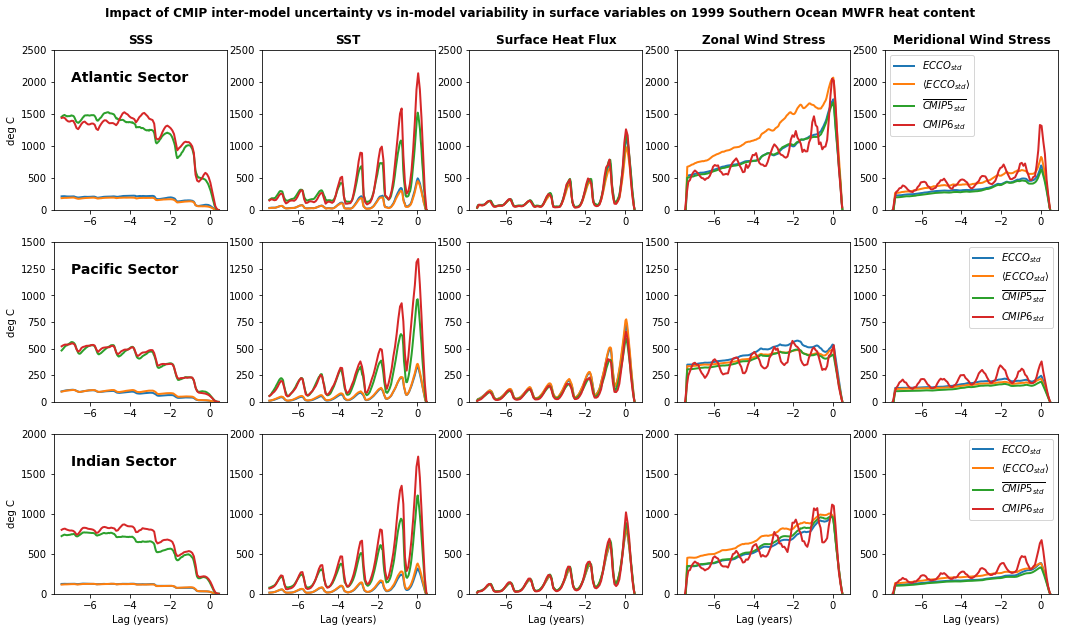

In [13]:
fig=plt.figure(figsize=(18,10))
ip=1    
plots_dir='../plots/'
    
ylims={'atl':[0,2500],'pac':[0,1500],'ind':[0 ,2000]}
var_labels = dict(zip(ecco_vars,['SSS','SST','Surface Heat Flux','Zonal Wind Stress','Meridional Wind Stress']))
basin_name=dict(zip(basins,['Atlantic Sector','Pacific Sector','Indian Sector']))
plot_label=['$ECCO_{std}$',r'$\langle ECCO_{std} \rangle$','$\overline{CMIP5_{std}}$','$CMIP6_{std}$']

pp=[[],[],[],[]]
    
for basin in basins:
    for var in ecco_vars:  
        cvar=cmip_ecco_map[var][0]
        dplot_cmip5=cmip5_out['{}X{}_absmean'.format(var,cvar)].mean(dim='year')
        dplot_cmip6=cmip6_out['{}X{}_absmean'.format(var,cvar)].mean(dim='year')
        
        dplot=[]
        for cvar in ecco3d_ecco_map[var]:
            dplot.append(eccoexf_out['{}X{}_absmean'.format(var,cvar)].mean(dim='year'))
        dplot.append(dplot_cmip5)
        dplot.append(dplot_cmip6)
            
        if ip>1:
            ax_old=ax
        ax=plt.subplot(3,5,ip)            
        #pp[0]=dplot_cmip.sel(basin=basin).plot(x='lag_years',linewidth=2,ax=ax,label='CMIP6 std')
        for ipp in range(0,4):
            pp[ipp]=dplot[ipp].sel(basin=basin).plot(x='lag_years',linewidth=2,ax=ax,label=plot_label[ipp])

        if var=='ADJsaltsurf':
            ax.set_ylabel('deg C')
            ax.annotate( basin_name[basin],(0.1,0.8),xycoords='axes fraction',fontsize=14,fontweight='bold')
        else:
            ax.set_ylabel('')
        if basin=='ind':
            ax.set_xlabel('Lag (years)')
        else:
            ax.set_xlabel('')
        if basin=='atl':
            ax.set_title(var_labels[var],fontweight='bold')
        else:
            ax.set_title('')
        ax.set_ylim(ylims[basin])
        ip=ip+1
    ax.legend()        
    plt.suptitle('Impact of CMIP inter-model uncertainty vs in-model variability in surface variables on {} Southern Ocean MWFR heat content'.format(year),fontweight='bold',y=0.94)
    plt.savefig('./convolvetseries_CMIPECCO_{}.png'.format(year)) 

### P.2. Look at spatial distributions at lag of peak SST impact in Pacific sector

Define function to plot non-ecco data similarly

In [12]:
def plot_array_proj(subplotcode,x,y,dplot,cmin,cmax,cmap,lon0,lat0,lat_cut,paral,units,show_colorbar=True):
    
    cbar=None
    ax = plt.subplot(subplotcode,projection=ccrs.LambertConformal(central_longitude=lon0,
                                        central_latitude=lat0,cutoff=lat_cut,standard_parallels=paral))
    out=ecco.plot_global(x,y,dplot,4326,cmin=cmin,cmax=cmax,ax=ax,\
                  plot_type='pcolormesh',show_colorbar=False,cmap=cmap,\
                  show_grid_lines = False)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(cmin,cmax))
    sm._A = []
    if show_colorbar:
        cbar_ax = plt.gcf().add_axes([0.94, 0.55-0.5*(subplotcode-233)/3, 0.02, 0.4])
        cbar = plt.colorbar(sm,ax=ax,cax=cbar_ax,label='[{}]'.format(units)) 
    ax.add_feature(cfeature.LAND, zorder=100)
    ax.add_feature(cfeature.COASTLINE,linewidth=0.5,zorder=101)
    ax.gridlines(crs=ccrs.PlateCarree(), 
                 linewidth=1.0,
                 color='black', 	
                 alpha=0.5, 
                 linestyle='--', 
                 draw_labels = False,zorder=102)
    return ax,cbar

In [13]:
# Setup grid projection variables
proj='LambertConformal'
lon0={'atl':0,'pac':-160,'ind':80}
lat0=-30
lat_cut=-20
paral=(-30,-50)
# Import libraries, define labels
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plot_label_1d=['$ECCO_{std}$',r'$\langle ECCO_{std} \rangle$','$CMIP5_{std}$','$CMIP6_{std}$']
plot_label_3d=['$ECCO_{std}$','$CMIP5_{std}$','$CMIP6_{std}$']
var_units = dict(zip(ecco_vars,['psu','$^{\circ}$C','W/m$^2$','N/m$^2$','N/m$^2$']))
var_labels = dict(zip(ecco_vars,['SSS','SST','Surface Heat Flux','Zonal Wind Stress','Meridional Wind Stress']))
basin_name=dict(zip(basins,['Atlantic Sector','Pacific Sector','Indian Sector']))
# Choose variable and basin
var='ADJthetasurf'
basin='pac'

In [14]:
dplot_1d=[]     
for cvar in ecco3d_ecco_map[var]:
    dplot_1d.append(eccoexf_out['{}X{}_absmean'.format(var,cvar)].mean(dim='year'))            
cvar=cmip_ecco_map[var][0]
dplot_1d.append(cmip5_out['{}X{}_absmean'.format(var,cvar)].mean(dim='year')) 
dplot_1d.append(cmip6_out['{}X{}_absmean'.format(var,cvar)].mean(dim='year'))     

# Find peak in basin integrated impacts
dmax=0
for ipp in range(0,4):
    if dplot_1d[ipp].sel(basin=basin).max()>dmax:
        imax=dplot_1d[ipp].sel(basin=basin).squeeze().argmax().data.compute()
        dmax=dplot_1d[ipp].sel(basin=basin).max()
        tmax=dplot_1d[ipp]['lag_years'][imax].data

dplot_3d=[]   
cvar=ecco3d_ecco_map[var][1]
dplot_3d.append(eccoexf_out['{}X{}'.format(var,cvar)].mean(dim='year').sel(basin=basin)) 
cvar=cmip_ecco_map[var][0]
dplot_3d.append(cmip5_out['{}X{}'.format(var,cvar)].mean(dim='year').sel(basin=basin))     
dplot_3d.append(cmip6_out['{}X{}'.format(var,cvar)].mean(dim='year').sel(basin=basin))   

/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-179.5 19.5
-180.0 20.0
-89.5 89.5
-90.0 90.0
20.50315462264151 179.4968553773585
20.00001 180.0
-89.5 89.5
-90.0 90.0


/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-179.5 19.5
-180.0 20.0
-89.5 89.5
-90.0 90.0
20.50315462264151 179.4968553773585
20.00001 180.0
-89.5 89.5
-90.0 90.0


/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


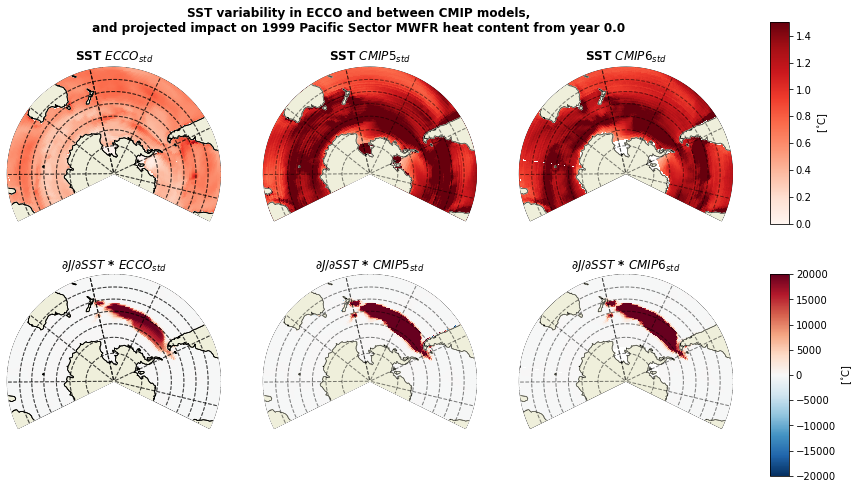

In [17]:
fig=plt.figure(figsize=(13,7))

cvar=ecco3d_ecco_map[var][0]          
dplot=ecco_exf_data[cvar]              
cmax=1.5
cmin=0
cmap='Reds'
f, ax=ecco.plot_proj_to_latlon_grid(ecco_grid.XC,ecco_grid.YC,dplot.compute(),user_lon_0=lon0[basin],user_lat_0=lat0,\
                                projection_type=proj,plot_type='pcolormesh', show_colorbar=False,dx=1,dy=1,\
                                cmap=cmap,subplot_grid=[2,3,1],cmin=cmin,cmax=cmax,lat_lim=lat_cut,
                                parallels=paral)[:2]
ax.set_title(var_labels[var]+' '+plot_label_3d[0],fontweight='bold')

cvar=cmip_ecco_map[var][0]    
dplot=cmip_spreads[cvar].mean(dim='time')
ax,cbar=plot_array_proj(232,dplot.lon,dplot.lat,dplot,cmin,cmax,cmap,
                            lon0[basin],lat0,lat_cut,paral,var_units[var],show_colorbar=False)
ax.set_title(var_labels[var]+' '+plot_label_3d[1],fontweight='bold')

dplot=cmip6_spreads[cvar].mean(dim='time')
ax,cbar=plot_array_proj(233,dplot.lon,dplot.lat,dplot.T,cmin,cmax,cmap,
                            lon0[basin],lat0,lat_cut,paral,var_units[var])
ax.set_title(var_labels[var]+' '+plot_label_3d[2],fontweight='bold')

cmax=20e3
cmin=-cmax
cmap='RdBu_r'      

for idp,dplot in enumerate(dplot_3d):        
    dplot=dplot.where(np.isfinite(dplot.lag_years),drop=True).sel(lag_years=tmax,method='nearest').squeeze()
    if ('i' in dplot.dims) or ('i_g' in dplot.dims):
        f, ax=ecco.plot_proj_to_latlon_grid(ecco_grid.XC,ecco_grid.YC,dplot,user_lon_0=lon0[basin],user_lat_0=lat0,\
                                projection_type=proj,plot_type='pcolormesh', show_colorbar=False,dx=1,dy=1,\
                                cmap=cmap,subplot_grid=[2,3,4+idp],cmin=cmin,cmax=cmax,lat_lim=lat_cut,
                                parallels=paral)[:2]
    else:
        if idp==1:
            scb=False
        else:
            scb=True
        ax,cbar=plot_array_proj(234+idp,dplot.lon,dplot.lat,dplot.transpose(),cmin,cmax,cmap,
                        lon0[basin],lat0,lat_cut,paral,'$^{\circ}$C',show_colorbar=scb)
    #print(ax.get_extent())
    ax.set_title('$\partial J/\partial {}$ * {}'.format(var_labels[var],plot_label_3d[idp]),fontweight='bold')

plt.suptitle('{} variability in ECCO and between CMIP models,\n and projected impact on {} {} MWFR heat content from year {:2.1f} '.format(var_labels[var],year,basin_name[basin],tmax)
             ,fontweight='bold')
plt.savefig('./'+var+'_'+basin+'_'+year+'_absall.png')

### Convert to python script 

In [ ]:
!jupyter nbconvert --to script convolve_examples.ipynb